In [2]:
import h5py
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections
from matplotlib import image
 
import matplotlib.animation as animation;
    
from math import *;

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')
import ablation_utils
import geom
import sonalleve
import transducers
import PBHEswig
from countlines import countlines

import imagemanip as imp;


%matplotlib inline

In [3]:
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')
import RSgpuPySwig
import PBHE_CUDA

In [99]:
import sys
del sys.modules['PBHE_CUDA']
del PBHE_CUDA

KeyError: 'PBHE_CUDA'

In [4]:
def isarray(a):
    try:
        shp = a.shape
        return True
    except:
        return False

def sonication_heating(T, CEM, duration, T0=None, CEMinit=None, Tmax=None, Freeflow=0):
    
    if T0 is not None:
        if isarray(T0):
            T=T0
        else:
            T[:] = T0
    if CEMinit is not None:
        if isarray(CEMinit):
            CEM=CEMinit
        else:
            CEM[:]=CEMinit
    if Tmax is None:
        Tmax = np.zeros_like(CEM)
    
    
    time=0
    ti=0
    buffsize=T.shape[0]
    tstep=dt*buffsize
    while time<duration :

        print( '%d%%' % (time/duration *100.0), end='\r')
        
        if (time + tstep > duration):
            buffsize = ceil((duration-time)/dt)
            tstep = dt*buffsize
            

        #PBHEswig.pbheSolve(Freeflow,dt,dx,dy,dz, Tmesh, Tdotmesh, kmesh, rhoCpmesh, 37.0, perfRate,0,buffsize-1 )
        PBHE_CUDA.Pennes_2ndOrder_GPU64_mesh(Freeflow,dt,dx,dy,dz, Tmesh, Tdotmesh, kmesh, rhoCpmesh, 37.0, perfRate,0,buffsize-1 )
        Rbase[:]=4
        Rbase[np.where(T[0] > 43.0, True, False)] = 2
         
        #update = np.where(T[buffsize-1] > Tmax, True, False)
        #Tmax[update] = T[buffsize-1][update]

        #time integrate to get the thermal dose
        CEM[:] += (dt/60.0)*np.sum( Rbase**(T[0:buffsize]-43), 0  )
        
        ti+=1
        time+=tstep
        T[0] = T[buffsize-1]
        
       
    update = np.where(T[buffsize-1] > Tmax, True, False)
    Tmax[update] = T[buffsize-1][update]
        
    return (Tmax, time)


def sonication_heating_physical_move(xdcTimes, xdcPoints, uamp, CEM, CEMvst, Tmax=None, frad=0.003, timeZero=0.0, Freeflow=0):
    
    if Tmax is None:
        Tmax = np.zeros_like(CEM)
    
    CEMvst[:]=0

    ti=0
    
    numSonicationPoints = len(xdcTimes)-1
    
    totalCooling=0
    
    #pre-calc HIFU-induced source term (not actual dT/dt, just what is due to HIFU)
   #Pr = sonalleve.calc_pressure_field(k0, uxyz, uamp, xrp, yrp, zrp)
    Pr = transducers.calc_pressure_field_cuda(k0,uxyz,unormals,uamp,xrp,yrp,zrp)
    Iavg = np.abs(Pr)**2 / (2.0*rho*c0)
    Tdot[:] = 2.0*(alpha_acc)*Iavg / (rhoCp)
    
    
    fzonesCentered=list( map ( lambda v: np.where( calcGridDist( v ) < frad), [pcentroid] ) )
    focalPntRise = list( map( lambda ell: np.mean(Tdot[ell]), fzonesCentered ) )
    
    elapsedTime = timeZero
    sonicationEndTimes = np.zeros(numSonicationPoints);
    
    ti=0
    while ti < numSonicationPoints :

        fzones =list( map ( lambda v: np.where( calcGridDist( v ) < frad), [pcentroid + xdcPoints[ti]] ) )
        TfocFilt =list( map( lambda ell: np.mean(T[0][ell]), fzones ) )
        
        dwell = min( list(map(lambda a,b: (50-a)/b, TfocFilt,focalPntRise)) )
        if dwell > 20.0:
            dwell = 20.0 
           
        #dwell = xdcTimes[ti+1] - xdcTimes[ti];
        
        monitorTemp = np.mean(T[0][monitorVolPix])
        if monitorTemp > 43:
            coolingTime = 10;
            print ('pre-focal cooling for= %4.1f, monitor temp=%3.1f C' % (coolingTime, monitorTemp), end='\n')
            Tdot[:]=0
            Tmax, duration = sonication_heating(T, Tdot, CEM, coolingTime, Tmax=Tmax, Freeflow=Freeflow )
            totalCooling+=duration
            ti-=1
        elif dwell >= 2*dt:
            
            #if dwell < 1:
             #   dwell = 1
                
            Tdot[:] = 2.0*(alpha_acc)* imp.shiftImageRegular3D(Iavg,xedges,yedges,zedges, -xdcPoints[ti]) / (rhoCp)

            fzone=np.where( calcGridDist( xdcPoints[ti] + [0,0,0.14] ) < 0.003)
            avgTdot = np.mean(Tdot[fzone])
            avgT = np.mean(T[0][fzone])    
            
            print ('dwell= %4.1f' % dwell, end=' ')
        
            print( 'updating position %d of %d: (%3.1f, %3.1f, t=%4.1f), monitor temp=%3.1f C, focal temp=%3.1f C' % \
                  (ti+1, numSonicationPoints, 100*xdcPoints[ti,0],100*xdcPoints[ti,1], elapsedTime, monitorTemp, avgT), end = '\n' )

            Tmax, duration = sonication_heating(T, CEM, dwell, Tmax=Tmax, Freeflow=Freeflow )
                      
           
        else:
            coolTime=4*dt
            print ('Cooling for %f' % coolTime)
            Tdot[:]=0
            Tmax, duration = sonication_heating(T, CEM, coolTime, Tmax=Tmax, Freeflow=Freeflow )
            totalCooling+=duration
            
        
        elapsedTime += duration
        sonicationEndTimes[ti] = duration
        CEMvst[ti] = CEM
        ti+=1
            
    return (Tmax, sonicationEndTimes,elapsedTime,totalCooling)

def sonication_heating_physical_move_nofeedback(xdcDwells, xdcWaits, xdcPoints, uamp, CEM, CEMvst, 
                                                TempOnvsTime, TempOffvsTime,
                                                Tmax=None, frad=0.003, timeZero=0.0, Freeflow=0, onroi=None, offroi=None):
    
    if Tmax is None:
        Tmax = np.zeros_like(CEM)
    
    CEMvst[:]=0

    ti=0
    
    numSonicationPoints = len(xdcDwells)
    
    totalCooling=0
    
    #pre-calc HIFU-induced source term (not actual dT/dt, just what is due to HIFU)
    #Pr = sonalleve.calc_pressure_field(k0, uxyz, uamp, xrp, yrp, zrp)
    Pr = transducers.calc_pressure_field_cuda(k0,uxyz,unormals,uamp,xrp,yrp,zrp)
    Iavg = np.abs(Pr)**2 / (2.0*rho*c0)
    Tdot[:] = 2.0*(alpha_acc)*Iavg / (rhoCp)
    
    elapsedTime = timeZero
    sonicationEndTimes = np.zeros(numSonicationPoints);
    
    if onroi is None:
        onroi= (calcGridDist( [0,0,0.14] ) < 0.005)
    
        
    ti=0
    while ti < numSonicationPoints :
        
        print('%d / %d' % (ti+1, numSonicationPoints), end =' ')
        
        dwell = xdcDwells[ti];
        Tdot[:] = 2.0*(alpha_acc)* imp.shiftImageRegular3D(Iavg,xedges,yedges,zedges, -xdcPoints[ti]) / (rhoCp)
        Tmax, duration = sonication_heating(T, CEM, dwell, Tmax=Tmax, Freeflow=Freeflow )
        
        elapsedTime += duration
        
        wait = xdcWaits[ti];
        Tdot[:] = 0
        Tmax, duration = sonication_heating(T, CEM, wait, Tmax=Tmax, Freeflow=Freeflow )
        
        elapsedTime += duration
        sonicationEndTimes[ti] = elapsedTime
        CEMvst[ti] = CEM
        TempOnvsTime[ti] = np.mean(T[0][onroi])
        if offroi is None:
            TempOffvsTime[ti] = np.mean(T[0])
        else:
            TempOffvsTime[ti] = np.mean(T[0][offroi])
        ti+=1
            
    return (Tmax, sonicationEndTimes, elapsedTime)

# Trajectory definition

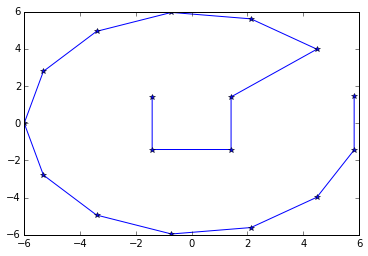

In [5]:
maxR_mm = 10
turnspace_mm=4
minR_mm = turnspace_mm / 2.0
z_mm = 140;

nturns = ceil( (maxR_mm - minR_mm)/turnspace_mm )

avgSpeed_mm_per_sec=0.3
focalpoint_dwell_seconds=9.5
wait=2.0

turn_radii_mm = minR_mm + turnspace_mm*np.arange(0,nturns)
num_sonications_per_turn = np.array(np.round( (2*pi*turn_radii_mm/avgSpeed_mm_per_sec) / focalpoint_dwell_seconds),dtype=int);

num_sonications_total = np.sum(num_sonications_per_turn, dtype=int)
focalpoint_coords_mm = np.zeros([num_sonications_total, 3])
pass_relative_amplitudes = np.zeros([num_sonications_total, 256])

turnIdxStart=0;
for n in range(0,nturns):
    ns = num_sonications_per_turn[n]
    phis = np.arange(1,ns+1)*(2.0*pi/ns) + 0.5*(2.0*pi/ns)
    x = turn_radii_mm[n]*np.cos(phis)
    y = turn_radii_mm[n]*np.sin(phis)
    z = z_mm*np.ones(ns);
    
    i = turnIdxStart
    
    focalpoint_coords_mm[i:(i+ns),0] = x;
    focalpoint_coords_mm[i:(i+ns),1] = y;
    focalpoint_coords_mm[i:(i+ns),2] = z;
    
    turnIdxStart += ns
    
plt.plot( focalpoint_coords_mm[:,0], focalpoint_coords_mm[:,1], '*-' )

In [18]:
num_sonications_per_turn

array([ 4, 13])

In [18]:
(T[0][list( map ( lambda v: ( calcGridDist( v ) < 0.005), [[0,0,0.14]] ) )]).shape

(568,)

In [19]:
np.mean(T[0][list( map ( lambda v: ( calcGridDist( v ) < 0.005), [[0,0,0.14]] ) )])

0.0

In [22]:
(calcGridDist( [0,0,0.14] ) < 0.005).shape

(80, 80, 80)

In [21]:
q = np.array([0, 10, 2.0 ,30.0])
test = {'qq':q}

In [65]:
test['qq'][0]=4

array([  4.,  13.])

In [63]:
q[0] = 11.0

In [24]:
x0 = [1,20,3,4]

In [31]:
x1 = [0,19,2,3]

In [32]:
x1 < x0

True

In [41]:
x,y,z=test()

ValueError: need more than 2 values to unpack

In [40]:
def test():
    return (1,2,None)

# Simulation

In [6]:
uxyz = sonalleve.get_sonalleve_xdc_vecs()
unormals = [0,0,0.14] - uxyz

f0 = 1.2e6
c0 = 1540
k0 = 2.0*pi*(f0/c0)

## Grid definition

In [7]:
Nx = 60
Ny = 60
Nz = 60
#Nt = 6
dt = 0.1

nacq0 = num_sonications_total
nacq1 = num_sonications_total

dwell_time0 = focalpoint_dwell_seconds
dwell_time1 = focalpoint_dwell_seconds
wait_time = wait

maxDwell=dwell_time0
if maxDwell < dwell_time1:
    maxDwell=dwell_time1
Nt = round(maxDwell/dt)

xedges = 1e-2*np.linspace(-3.0, 3.0,Nx+1)
yedges = 1e-2*np.linspace(-3.0, 3.0,Ny+1)
zedges = 1e-2*np.linspace(11.0, 17.0,Nz+1)

xrp = xedges[0:Nx]
yrp = yedges[0:Ny]
zrp = zedges[0:Nz]

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

dx = xrp[1]-xrp[0]
dy = yrp[1]-yrp[0]
dz = zrp[1]-zrp[0]

#dt = 0.1
res = np.array([dt,dx,dy,dz])
voxVol=dx*dy*dz

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<0) ))[0][0]

roiVolumeZPix = np.where(np.logical_and( (zrp>=zplane-0.01) , (zrp<=zplane+0.01) ))[0]

roiOnTarget = np.logical_and( np.sqrt(gxp**2 + gyp**2) <= (1e-3*maxR_mm), np.abs(gzp-0.14) <= 0.005 )
roiOffTarget = np.logical_and( np.sqrt(gxp**2 + gyp**2) <= 0.025, np.abs(gzp-0.14) <= 0.015 )
roiOffTarget = np.logical_and(roiOffTarget, np.logical_not(roiOnTarget) ) 

monitorVolXPix = np.where(np.logical_and( (xrp>=-0.01) , (xrp<=0.01) ))[0]
monitorVolYPix = np.where(np.logical_and( (yrp>=-0.01) , (yrp<=0.01) ))[0]
monitorVolZPix = np.where(np.logical_and( (zrp>=0.11) , (zrp<=0.115) ))[0]

monitorVolPix = np.meshgrid(monitorVolXPix, monitorVolYPix, monitorVolZPix, sparse=False, indexing='ij'
                            )
roiExtra = np.logical_and( np.sqrt(gxp**2 + gyp**2) <= (1e-3*1.5*maxR_mm), np.abs(gzp-0.14) <= 0.0125 )

In [8]:
Nt

95

In [9]:
# ----- allocate numpy data arrays --- #
T = np.zeros([Nt,Nx,Ny,Nz])
Tdot = np.zeros([Nx,Ny,Nz])
kdiff = np.zeros([Nx,Ny,Nz])
rhoCp = np.zeros([Nx,Ny,Nz])

# ---- Create C++ mesh objects ---
Tmesh = PBHEswig.mesh4d()
Tdotmesh = PBHEswig.mesh34d();
kmesh = PBHEswig.mesh3d();
rhoCpmesh = PBHEswig.mesh3d();

# ----- tie data arrays to mesh objects (to pass to C++) ---
# the data in each mesh can now be accessed/manipulated from python via the arrays, 'T', 'Tdot', etc.
PBHEswig.ShareMemoryMesh4(T, res, Tmesh)
PBHEswig.ShareMemoryMesh34(Tdot, res, Tdotmesh)
PBHEswig.ShareMemoryMesh3(kdiff, res[1:4], kmesh)
PBHEswig.ShareMemoryMesh3(rhoCp, res[1:4], rhoCpmesh)

CEM0 = np.zeros([Nx,Ny,Nz])
CEM1 = np.zeros([Nx,Ny,Nz])
Rbase = np.zeros([Nx,Ny,Nz])

CEM0vsTime=np.zeros([nacq0,Nx,Ny,Nz])
CEM1vsTime=np.zeros([nacq1,Nx,Ny,Nz])

Tmax0 = np.zeros([Nx,Ny,Nz])
Tmax1 = np.zeros([Nx,Ny,Nz])

In [18]:
del Tmesh,Tdotmesh,kmesh,rhoCpmesh, T,Tdot,kdiff,rhoCp, CEM0, CEM1, Rbase, CEM0vsTime, CEM1vsTime, Tmax0, Tmax1

In [10]:
dx

0.0010000000000000009

## Initialize

In [11]:
#initial conditions
Cp=3700
rho=1000
ktdiffusion=0.6
kdiff[:] = ktdiffusion;
rhoCp[:] = rho*Cp;

CEM0[:] =0
CEM1[:] = 0

perfRate = 0.00;

alpha_acc = 1.0; #Np/m (5.75 Np/m = 0.5 dB/cm)

CFLnum = ktdiffusion/(rho*Cp)*dt*(dx**-2 + dy**-2 + dz**-2 )
CFLnum

0.048648648648648561

# Acoustic Fields

In [12]:
#single

N = uxyz.shape[0]

Ispta0 = 2e7;

uamp0 = np.ones(N) / N

#P0 = sonalleve.calc_pressure_field(k0, geom.translate3vecs(uxyz, np.array([0, 0, 0 ]) ), uamp0, xrp, yrp, zrp)
#Pr = sonalleve.calc_pressure_field(k0, uxyz, uamp, xrp, yrp, zrp)
P0 = transducers.calc_pressure_field_cuda(k0,uxyz,unormals,uamp0,xrp,yrp,zrp)
I0 = np.abs(P0)**2 / (2.0*rho*c0)

powerRenorm = (Ispta0/np.max(I0))
I0 *= powerRenorm

#update uamp0
uamp0 *= sqrt(powerRenorm)

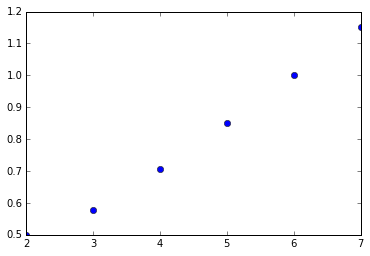

In [9]:
Mlist = np.arange(2,8,1)
plt.plot(Mlist,1/np.sqrt(2*(1-np.cos(2*pi/Mlist))),'o'  )

### Multi-focus pattern def

In [13]:


d=0.004;
h=d*sin(pi/3);
triangle,h = geom.equilateral_tri(d)
pxyz=triangle

M=3
#ring,radius = geom.ring(d,M)
#h=radius
#pxyz=ring;

pxyz[:,2]=0.14
p0 = 1e7*np.ones(len(pxyz));

pcentroid = np.mean(pxyz,0);

uamp1 = transducers.get_focused_element_vals(k0, uxyz, pxyz, p0 )
#uamp1 = sqrt(powerRenorm)*uamp0
uamp1 = sqrt(powerRenorm)*( uamp1  ) / sum(abs(uamp1))

#P1 = sonalleve.calc_pressure_field(k0, uxyz, uamp1, xrp, yrp, zrp)
P1 = transducers.calc_pressure_field_cuda(k0, uxyz, unormals, uamp1, xrp, yrp, zrp)
I1reg = np.abs(P1)**2 / (2.0*rho*c0)

In [14]:
# Execute with 'modifyPower=1' to make the multi-focus spots each correspond to a specfic intensity. 
# Otherwise the total input power will set to the same as in the single focus case, so multi-focal spots 
# will have lower intensity in each spot

modifyPower=0

if modifyPower:
    #Ispta1 = 1.2e7;
    #Ispta1 = Ispta0
    #powerAdj1 = (Ispta1/np.max(I1reg))
    
    powerAdj1=1.5
    Ispta1=powerAdj1*Ispta0
    uamp1adj = sqrt(powerAdj1)*( uamp1  ) 
else:
    Ispta1 = np.max(I1reg)
    powerAdj1=1;
    uamp1adj = sqrt(powerAdj1)*( uamp1  ) 
    

I1 =powerAdj1*I1reg 

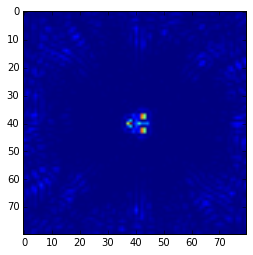

In [13]:
plt.imshow(I1reg[:,:,focplaneZpix])

# Sonication 0

In [15]:
npass0=1
CEM0passFinal = np.zeros([npass0,Nx,Ny,Nz])
Tmax0passFinal = np.zeros([npass0,Nx,Ny,Nz])
T0passFinal = np.zeros([npass0,Nx,Ny,Nz])
CEM0vsTimevsPass = np.zeros([npass0,nacq1,Nx,Ny,Nz])
sonicationEndTimesvsPass0 = np.zeros([npass0, nacq0])
Temp0vsTimevsPassON = np.zeros([npass0, nacq0])
Temp0vsTimevsPassOFF = np.zeros([npass0, nacq0])

In [38]:
del CEM0passFinal, Tmax0passFinal, T0passFinal, CEM0vsTimevsPass , sonicationEndTimesvsPass0, Temp0vsTimevsPassON, Temp0vsTimevsPassOFF

In [16]:
T0=37
T[0][:]=T0
CEM0[:]=0
CEM0vsTime[0][:]=0
Tmax0[:]=0


endTime=0.0;
try:
    del xdcDwells, xdcWaits, xdcPoints
except NameError:
   1
    
xdcDwells = dwell_time1*np.ones([nacq0])
xdcWaits = wait_time*np.ones([nacq0])
xdcPoints = 1e-3*focalpoint_coords_mm
xdcPoints[:,2]=0

for n in range(0,npass0):
    print('pass # ', n+1)

    Tmax0, sonicationEndTimes, elapsedTime = sonication_heating_physical_move_nofeedback(
                                                    xdcDwells,xdcWaits, xdcPoints, uamp0,
                                                    CEM0, CEM0vsTime, Temp0vsTimevsPassON[n], Temp0vsTimevsPassOFF[n],
                                                    Tmax=Tmax0, timeZero=endTime, Freeflow=1, onroi=roiOnTarget, offroi=roiOffTarget)
    
    Tfinal0 = T[0].copy()
    
    CEM0passFinal[n] = CEM0;
    Tmax0passFinal[n] = Tmax0
    T0passFinal[n] = Tfinal0
    CEM0vsTimevsPass[n] = CEM0vsTime;
    sonicationEndTimesvsPass0[n] = sonicationEndTimes
    
    endTime = sonicationEndTimes[-1];

pass #  1


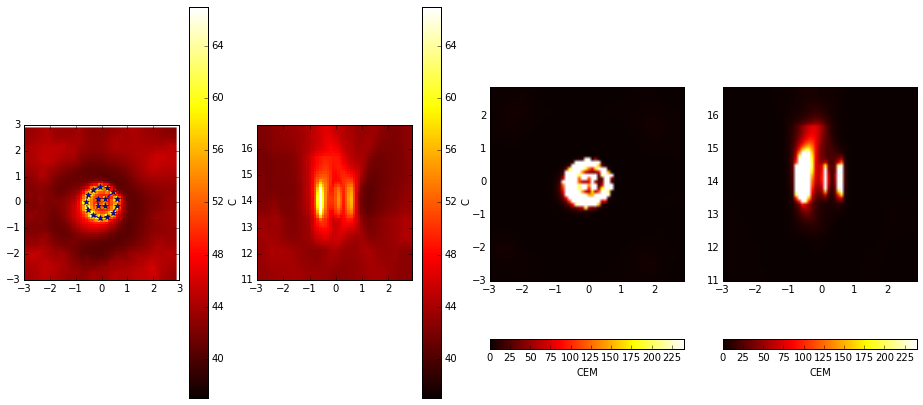

In [17]:
passnum=0

n=-1
fig=plt.figure(figsize=(16,7))
ax1=fig.add_subplot(141)

colormap = image.cm.hot

im1=ax1.imshow(np.transpose(Tmax0passFinal[passnum][:,:,focplaneZpix]), vmin=T0,vmax=(T0+30), cmap=colormap, origin='lower', 
               extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]], interpolation="none")

ax1.plot(100*xdcPoints[:,0], 100*xdcPoints[:,1], 'b--*')

ax2=fig.add_subplot(142)
im2=ax2.imshow(np.transpose(Tmax0passFinal[passnum][:,floor(Ny/2),:]), vmin=T0,vmax=(T0+30), cmap=colormap, origin='lower', 
               extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]], interpolation="none")

ax3=fig.add_subplot(143)
im3=ax3.imshow(np.transpose(CEM0vsTimevsPass[passnum][n, :,:,focplaneZpix]), vmin=0,vmax=240, cmap=colormap, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]])
#ax3.plot(x1,y1,'*--')
ax4=fig.add_subplot(144)
im4=ax4.imshow(np.transpose(CEM0vsTimevsPass[passnum][n, :,floor(Ny/2),:]), vmin=0,vmax=240, cmap=colormap, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]])


cb1=plt.colorbar(mappable=im1, ax=ax1, orientation='vertical')
cb2=plt.colorbar(mappable=im2, ax=ax2, orientation='vertical')
cb3=plt.colorbar(mappable=im3, ax=ax3, orientation='horizontal')
cb4=plt.colorbar(mappable=im4, ax=ax4, orientation='horizontal')
cb1.set_label('C')
cb2.set_label('C')
cb3.set_label('CEM')
cb4.set_label('CEM')

# Sonication 1

In [42]:
npass1=1
CEM1passFinal = np.zeros([npass1,Nx,Ny,Nz])
Tmax1passFinal = np.zeros([npass1,Nx,Ny,Nz])
T1passFinal = np.zeros([npass1,Nx,Ny,Nz])
CEM1vsTimevsPass = np.zeros([npass1,nacq1,Nx,Ny,Nz])
sonicationEndTimesvsPass = np.zeros([npass1, nacq1])
Temp1vsTimevsPassON = np.zeros([npass1, nacq1])
Temp1vsTimevsPassOFF = np.zeros([npass1, nacq1])

In [41]:
del CEM1passFinal, Tmax1passFinal, T1passFinal, CEM1vsTimevsPass , sonicationEndTimesvsPass, Temp1vsTimevsPassON, Temp1vsTimevsPassOFF

In [43]:
T0=37
T[0][:]=T0
CEM1[:]=0
CEM1vsTime[0][:]=0
Tmax1[:]=0


endTime=0.0;
try:
    del xdcDwells, xdcWaits, xdcPoints
except NameError:
   1
    
xdcDwells = dwell_time1*np.ones([nacq1])
xdcWaits = wait_time*np.ones([nacq1])
xdcPoints = 1e-3*focalpoint_coords_mm
xdcPoints[:,2]=0

for n in range(0,1):
    print('pass # ', n+1)

    Tmax1, sonicationEndTimes, elapsedTime = sonication_heating_physical_move_nofeedback(
                                                    xdcDwells,xdcWaits, xdcPoints, uamp1adj,
                                                    CEM1, CEM1vsTime, Temp1vsTimevsPassON[n], Temp1vsTimevsPassOFF[n], 
                                                    Tmax=Tmax1, timeZero=endTime, Freeflow=1, onroi=roiOnTarget, offroi=roiOffTarget)
    
    Tfinal1 = T[0].copy()
    
    CEM1passFinal[n] = CEM1;
    Tmax1passFinal[n] = Tmax1
    T1passFinal[n] = Tfinal1
    CEM1vsTimevsPass[n] = CEM1vsTime;
    sonicationEndTimesvsPass[n] = sonicationEndTimes
    
    endTime = sonicationEndTimes[-1];

pass #  1


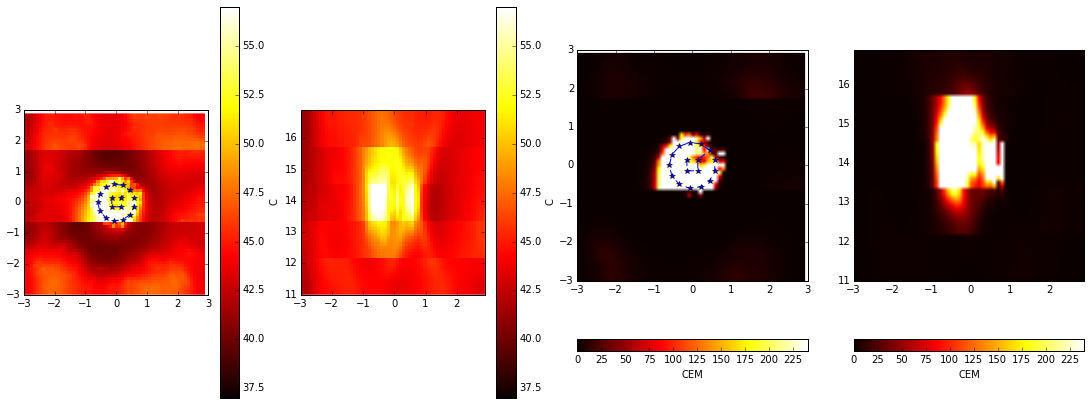

In [44]:
passnum=0


n=-1

fig=plt.figure(figsize=(19,7))
ax1=fig.add_subplot(141)

colormap = image.cm.hot

im1=ax1.imshow(np.transpose(Tmax1passFinal[passnum][:,:,focplaneZpix]), vmin=T0,vmax=T0+20, cmap=colormap, origin='lower', 
               extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]], interpolation="none")
ax1.plot(100*xdcPoints[:,0], 100*xdcPoints[:,1], 'b--*')


ax2=fig.add_subplot(142)
im2=ax2.imshow(np.transpose(Tmax1passFinal[passnum][:,floor(Ny/2),:]), vmin=T0,vmax=T0+20, cmap=colormap, origin='lower', 
               extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]], interpolation="none")

ax3=fig.add_subplot(143)
im3=ax3.imshow(np.transpose(CEM1vsTimevsPass[passnum][n, :,:,focplaneZpix]), vmin=0,vmax=240, cmap=colormap, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*yrp[0], 100*yrp[-1]])
ax3.plot(100*xdcPoints[:,0], 100*xdcPoints[:,1], 'b--*')
ax4=fig.add_subplot(144)
im4=ax4.imshow(np.transpose(CEM1vsTimevsPass[passnum][n, :,floor(Ny/2),:]), vmin=0,vmax=240, cmap=colormap, origin='lower', extent=[100*xrp[0], 100*xrp[-1], 100*zrp[0], 100*zrp[-1]])


cb1=plt.colorbar(mappable=im1, ax=ax1, orientation='vertical')
cb2=plt.colorbar(mappable=im2, ax=ax2, orientation='vertical')
cb3=plt.colorbar(mappable=im3, ax=ax3, orientation='horizontal')
cb4=plt.colorbar(mappable=im4, ax=ax4, orientation='horizontal')
cb1.set_label('C')
cb2.set_label('C')
cb3.set_label('CEM')
cb4.set_label('CEM')

In [21]:
np.sum(CEM1[roiOnTarget]>240)

1551

In [22]:
np.sum(CEM1[roiExtra]>240)

2246

array([  11.5,   23. ,   34.5,   46. ,   57.5,   69. ,   80.5,   92. ,
        103.5,  115. ,  126.5,  138. ,  149.5,  161. ,  172.5,  184. ,
        195.5])

In [30]:
maxxp=1
t0 = sonicationEndTimesvsPass0[0:maxxp].flatten()
TcurveOn0 = Temp0vsTimevsPassON[0:maxxp].flatten()
TcurveOff0 = Temp0vsTimevsPassOFF[0:maxxp].flatten()


In [31]:
maxxp=1
t1 = sonicationEndTimesvsPass[0:maxxp].flatten()
TcurveOn1 = Temp1vsTimevsPassON[0:maxxp].flatten()
TcurveOff1 = Temp1vsTimevsPassOFF[0:maxxp].flatten()

In [64]:
h5name = "C:\\Users\\Vandiver\\Data\\simulations\\circ_nfoc\\nfoci_circ_triangle_2_d=3.5mm.hdf5"

In [65]:


f = h5py.File(h5name, "w")

dset= f.create_dataset("geom/trajectory", data=1e-3*focalpoint_coords_mm)
f.flush()

dset = f.create_dataset("geom/gridx", data=gxp)
dset.attrs['xp']=xrp
f.flush()

dset = f.create_dataset("geom/gridy", data=gyp)
dset.attrs['yp']=zrp
f.flush()

dset = f.create_dataset("geom/gridz", data=gzp)
dset.attrs['zp']=zrp
f.flush()

dset = f.create_dataset("geom/ROION", data=roiOnTarget)
f.flush()

dset = f.create_dataset("geom/ROIOFF", data=roiOffTarget)
f.flush()

dset = f.create_dataset("1/CEM", data=CEM0vsTimevsPass)

dset.attrs['T0']=T0
dset.attrs['kdiff']=ktdiffusion
dset.attrs['alpha']=alpha_acc
dset.attrs['perfRate']=perfRate
dset.attrs['d']=d
dset.attrs['nfoc']=1
dset.attrs['xp']=xrp
dset.attrs['zp']=zrp
dset.attrs['yp']=yrp
dset.attrs['resolution'] = [dt,dx,dy,dz]
dset.attrs['tstops'] = t0
dset.attrs['passes'] = maxxp
dset.attrs['wait'] = wait_time
dset.attrs['dwell'] = dwell_time0
dset.attrs['Ispta'] = Ispta0
dset.attrs['uamp'] = uamp0
f.flush()

dset = f.create_dataset("1/TonCurve", data=TcurveOn0)
dset.attrs['tstops'] = t0
f.flush()
dset = f.create_dataset("1/ToffCurve", data=TcurveOff0)
dset.attrs['tstops'] = t0

f.flush()



f.close()

In [66]:
#h5name = "C:\\Users\\Vandiver\\Data\\simulations\\circ_nfoc\\nfoci_movingring.hdf5"

f = h5py.File(h5name, "r+")

dset = f.create_dataset("%d/CEM" % M, data=CEM1vsTimevsPass)
dset.attrs['nfoc']=M
dset.attrs['passes'] = maxxp
dset.attrs['kdiff']=ktdiffusion
dset.attrs['alpha']=alpha_acc
dset.attrs['perfRate']=perfRate
dset.attrs['d']=d
dset.attrs['xp']=xrp
dset.attrs['zp']=zrp
dset.attrs['yp']=yrp
dset.attrs['resolution'] = [dt,dx,dy,dz]
dset.attrs['tstops'] = t1
dset.attrs['wait'] = wait_time
dset.attrs['dwell'] = dwell_time1
dset.attrs['uamp'] = uamp1adj
f.flush()
dset = f.create_dataset("%d/TonCurve" % M, data=TcurveOn1)
dset.attrs['tstops'] = t1
f.flush()
dset = f.create_dataset("%d/ToffCurve" % M, data=TcurveOff1)
dset.attrs['tstops'] = t1

f.flush()
f.close()

In [49]:
M

3

In [46]:
f.close()

## Single vs. multi compare

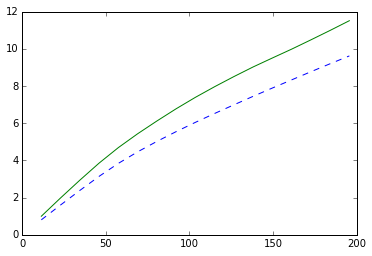

In [32]:
maxp=1
t0 = sonicationEndTimesvsPass0[0:maxp].flatten()
Tcurve0 = Temp0vsTimevsPassON[0:maxp].flatten()

t1 = sonicationEndTimesvsPass[0:maxp].flatten()
Tcurve1 = Temp1vsTimevsPassON[0:maxp].flatten()

plt.plot( t0, Tcurve0 - T0, '--' )
plt.plot( t1, Tcurve1 - T0 )


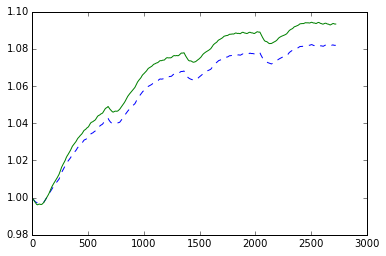

In [45]:
maxp=4
t0 = sonicationEndTimesvsPass0[0:maxp].flatten()
ratio0 = Temp0vsTimevsPassON[0:maxp].flatten()/Temp0vsTimevsPassOFF[0:maxp].flatten()

t1 = sonicationEndTimesvsPass[0:maxp].flatten()
ratio1 = Temp1vsTimevsPassON[0:maxp].flatten()/ Temp1vsTimevsPassOFF[0:maxp].flatten()

plt.plot( t0, ratio0, '--' )
plt.plot( t1, ratio1 )

In [30]:
CEMcurve0 = np.mean( CEM0vsTimevsPass[0:2].reshape([2*nacq0,Nx,Ny,Nz]))

In [123]:
CEMcurve0=list( map( lambda p,n: np.mean(CEM0vsTimevsPass[p][n][roiOnTarget]), [0,0], [0,1] ) )

In [46]:
np.mean(CEM1vsTime[0][roiOnTarget])

454540.88794299535

In [51]:
lesionvol0=list(map( lambda ti: np.sum( CEM0vsTime[ti] > 240) ,  range(0,nacq0) ))
lesionvol1=list(map( lambda ti: np.sum( CEM1vsTime[ti] > 240) ,  range(0,nacq1) ))

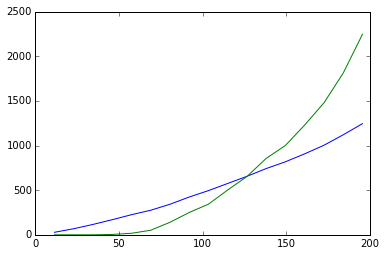

In [54]:
plt.plot(t0,lesionvol0)
plt.plot(t1,lesionvol1)

In [55]:
np.mean(CEM1vsTime[2] - CEM1)

0.0

In [56]:
fzonesCentered=list( map ( lambda v: np.where( calcGridDist( v ) < 0.005), [[0,0,0.14]] ) )

In [50]:
fzonesCentered

[(array([34, 34, 34, ..., 46, 46, 46], dtype=int64),
  array([37, 37, 37, ..., 41, 42, 42], dtype=int64),
  array([33, 34, 35, ..., 36, 34, 35], dtype=int64))]

In [71]:
40/1250

0.032

In [71]:
np.mean(T[0][roiOnTarget])

43.916665101705711

In [47]:
qq=Rbase**(T-43)

In [43]:
np.sum( qq > 240, (1,2,3)).shape

(60,)

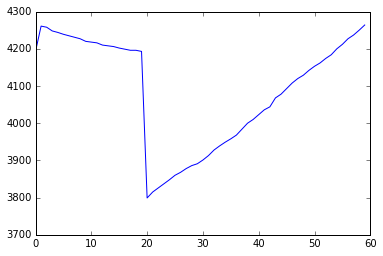

In [42]:
plt.plot( np.sum( qq > 240, (1,2,3))  )

In [77]:
np.max( np.sum(qq,0) > 240)  

True

In [80]:
np.sum(np.sum(qq,0) > 240

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, 

In [13]:
Rbase[np.where(T[0] > 3.0, True, False)].shape

(0,)

In [17]:
np.where(T[0] > 3.0, True, False).shape

(70, 70, 70)

In [66]:
x=np.zeros([3,4])
p0 = np.array([0,1,2,3])
p1 = np.array([10,11])
p2 = np.array([20,21,22])
y=list([p0, p1, p2])

In [67]:
grid = np.meshgrid( *tuple(y), indexing='ij')

In [86]:
xx=list(map( lambda *arg: len(*arg) , tuple(y)))

TypeError: len() takes exactly one argument (3 given)

In [85]:
xx

[4, 2, 3]

(array([0, 1, 2, 3]), array([10, 11]), array([20, 21, 22]))

# Test param_grid output to hdf5

In [19]:
import h5py
import numpy as np

In [15]:
f = h5py.File("junkTestFile.h5", "w")

In [14]:
f.close()

ValueError: Not a file id (Not a file id)

In [ ]:

f = h5py.File(h5name, "w")

def write_xyz_simulation_coords(f, gxp=None,gyp=None,gzp=None,xrp=None,yrp=None,zrp=None, roiON=None, roiOFF=None, roiEXTRA=None)

    if gxp is not None:
        dset = f.create_dataset("geom/gridx", data=gxp)
        if xrp is not None:
            dset.attrs['xp']=xrp
        f.flush()

    if gyp is not None:
        dset = f.create_dataset("geom/gridy", data=gyp)
        if yrp is not None:
            dset.attrs['yp']=yrp
        f.flush()

    if gzp is not None:
        dset = f.create_dataset("geom/gridz", data=gzp)
        if zrp is not None:
            dset.attrs['zp']=zrp
        f.flush()
    
    if roiON is not None:
        dset = f.create_dataset("geom/ROION", data=roiON)
        f.flush()

    if roiOFF is not None:
        dset = f.create_dataset("geom/ROIOFF", data=roiOFF)
        f.flush()
        
    if roiEXTRA is not None:
        dset = f.create_dataset("geom/ROIEXTRA", data=roiEXTRA)
        f.flush()

    return f

def write_parameter_space(f, sim_result, SetOfParamArrays, NamesOfParams, units=None, scoringfunc=None)
"""
Write the parameter space definition for the param_grid.
 * SetOfParamArrays is a list or array of vectors representing the sampled across each dimension.
 * NamesOfParams is a list of strings with the name of each parameter
 * 'units=' is an optional keyword containing the parameter unit definition
E.g., 
p0 = np.arange(0.2, 0.3, 0.05 ) #speed
p1 = np.arange(3.0, 9.0, 1.0 )  #dwell
p2 = np.arange(2.0, 6.0, 1.0 )  #wait
...
paramvecs = [ p0, p1, p2, ...]
names = ["speed", "dwell", "wait"]
units = ["mm/sec","sec","sec"]

write_parameter_space(f, paramvecs, names, units=units)

"""
    
    Ndims = len(SetOfParamArrays)
        
    if Ndims >0:
        dset = f.create_dataset("param_grid",data=sim_result)
        f.flush()
    else:
        return
    
    if type(SetOfParamArrays) == list:
        tupleOfParams = tuple(SetOfParamArrays)
    elif type(SetOfParamArrays) == np.ndarray
        tupleOfParams = tuple(SetOfParamArrays.tolist())
    
    #param_grid = np.meshgrid( *tupleOfParams , indexing='ij')
    
    param_dims = list(map( lambda *arg: len(*arg) , tupleOfParams))
    
    dset.attrs['Ndims']=Ndims
    dset.attrs['dims']=param_dims
    dset.attrs['names']=NamesOfParams
    if units is not None:
        dset.attrs['units']=units
        
    if scoringfunc is not None:
        dset.attrs['scoringfunc']=scoringfunc
    
    for n in range(0,Ndims):
        pname = "p%d" % n
        dset.attrs[pname]=SetOfParamArrays[n]

        f.flush()

    return f


def read_parameter_space(f,dset=None)
"""
Return a list of arrays containing the parameter space points.
This can be used to construct a mesh-style grid like

setOfParamArrays = read_parameter_space(f)
param_grid = np.meshgrid( *tuple(setOfParamArrays) , indexing='ij')

"""
    
    if dset is None:
        dset = f['param_grid']
    
    Ndims = len(SetOfParamArrays)
        
    Ndims = dset.attrs['Ndims']

    SetOfParamArrays=[]
    for n in range(0,Ndims):
        pname = "p%d" % n
        SetOfParamArrays.append(dset.attrs[pname])

    return SetOfParamArrays


dset = f.create_dataset("geom/ROION", data=roiOnTarget)
f.flush()

dset = f.create_dataset("geom/ROIOFF", data=roiOffTarget)
f.flush()

f.flush()

f.close()